# Naive Attempt at Sentence Embedding, Clustering, and then Decoding Representations.

This file experiments with (1) creating a sentence-level embedding space with BERT embeddings based on *only* LLM responses, (2) basic k-mean clustering + labeling, (3) decoding/paraphrase methods of the cluster centroids back to understandable sentence representations.


Install/import necessary libraries. For now we will be using Sentence-BERT for sentence level embeddings (paper: https://arxiv.org/abs/1908.10084, documentation: https://www.sbert.net/) 
Since no venv is set up yet, run the following:

!pip install transformers torch

!pip install -U sentence-transformers

(Disclaimer: only these were really needed to work on my (Kerria's) PC, but it'll probably vary from env to env.)


In [57]:
from sentence_transformers import SentenceTransformer, util


### Basic Examples
Create Embedding Model and run basic example (right now, it's displaying a warning: "to support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator")

In [58]:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# The sentences to encode
sentences = [
    "The weather is lovely today.",
    "It's so sunny outside!",
    "He drove to the stadium.",
]

# 2. Calculate embeddings by calling model.encode()
embeddings = embedding_model.encode(sentences)
print(embeddings.shape)
# [3, 384]

# 3. Calculate the embedding similarities
similarities = embedding_model.similarity(embeddings, embeddings) # similarity matrix, M[i][j] is how similar sentence i is to sentence j (should be symmetric), pretty sure this uses cosine similarity

C:\Users\Kerria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


(3, 384)


In [59]:
similarities

tensor([[1.0000, 0.6660, 0.1046],
        [0.6660, 1.0000, 0.1411],
        [0.1046, 0.1411, 1.0000]])

Direct inversion of an embedding to a sentence is impossible, but you can use paraphrasing/retrieval methods (but this would require some generative model). In this example, we'll put all the dataset sentences into some corpus, and then understandably represent a cluster centroid with the sentence(s) that are most close to the centroid's location in the embedding space.

Here's a basic example of it.

In [60]:
# corpus embeddings
corpus = ['This is a sentence.', 'BERT provides embeddings.', 'I like machine learning.']
corpus_embeddings = embedding_model.encode(corpus)

# query/reference embedding we are gonna find the most similar sentence in corpus to
query_embedding = embedding_model.encode('BERT helps with embeddings.')

# similarity scores
similarity_scores  = util.cos_sim(query_embedding, corpus_embeddings) # use util.cos_sim because format is in list not matrix

closest_sentence = corpus[similarity_scores.argmax()] # argm



In [61]:
closest_sentence 

'BERT provides embeddings.'

### Basic Clustering and Matching of Centroid representations (just answers)
Now let's do this with the clustering centroids of the ticket answers. For now, we will vectorize only LLM responses that are labeled as hallucinations. We will use k-means clustering and then identify the closest sentences to the centroids of each cluster. We will then be performing PCA and visualization of the clusters. Possible future directions include performing dimensionality reduction or re-defining dimensions on these centroid locations.

Dataset links: https://www.kaggle.com/competitions/ml-olympiad-detect-hallucinations-in-llms/data?select=train.csv


In [62]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd

In [63]:
df = pd.read_csv("helpdesk_customer_tickets.csv")

In [64]:
llm_responses = df["answer"]

Embeddings of llm_responses

In [65]:
embeddings = embedding_model.encode(llm_responses.tolist(), convert_to_tensor=False)

K-means clustering with scikit-learn. Do 5 clusters for now (?).

In [66]:
num_clusters = 5  # Define the number of clusters you want
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(embeddings)

In [ ]:
df

In [68]:
# looks like it clustered it by language, kind of a win?
print("Sentence Clustering:")
for i in range(num_clusters):
    print(f"\nCluster {i}:")
    print(df[df['cluster'] == i]['answer'].tolist())

Sentence Clustering:

Cluster 0:
['Gracias por su correo electrónico. Procesaremos su devolución para el Dell XPS. Espere más instrucciones pronto.', 'Caro Cliente,\n\nRecebemos sua solicitação urgente sobre a falha na aplicação de folha de pagamento. Nossa equipe está analisando o problema e fornecerá uma atualização assim que possível. Para mais informações, poderemos entrar em contato com <name> pelo <tel_num>. Fique tranquilo, estamos priorizando a restauração do seu serviço.\n\nAtenciosamente,\nSuporte ao Cliente da Firma de Consultoria de TI', 'Estamos trabalhando para resolver o problema. Por favor, tente novamente mais tarde. Desculpe pelo inconveniente.', 'Caro <name>, Lamentamos saber sobre o problema da tela sensível ao toque. Por favor, tente atualizar seus drivers e usar o Ferramenta de Diagnóstico do Surface. Se o problema persistir, nos avise.  Atenciosamente, Suporte ao Cliente', 'Caro <name>,\n\nObrigado pela sua consulta. O MacBook Air M1 suporta monitores externos, e

PCA and visualization. Now let's visualize the clusters in 2 dimensions using PCA.

- cluster 0 = spanish

- cluster 1 = French

- cluster 2 = German

- cluster 3 = Portuguse

- Cluster 4 = English

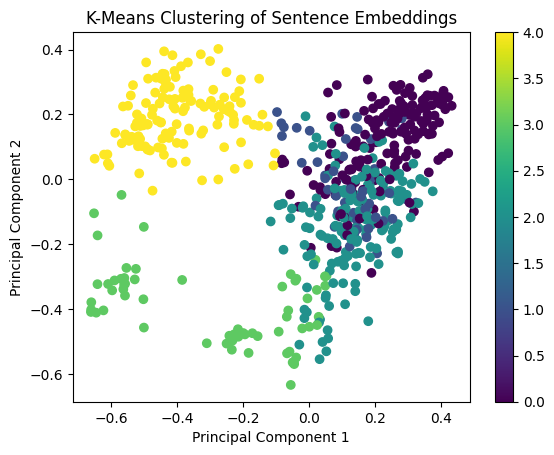

In [69]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Plot the clusters
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=df['cluster'], cmap='viridis')
plt.title('K-Means Clustering of Sentence Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()

Calculate the within cluster sum of squares or inertia. This is the within-cluster sum of squares. (lower = more compact, higher = more spread). Should use "elbow method" to select number of clusters: as you increase k, when the WCSS stops decreasing choose that number of clusters (i.e., smallest number of clusters with smallest WCSS score).

In [70]:
wcss = kmeans.inertia_
print(wcss)

364.68438720703125


Decode/find closest examples to centroid centers. Right now we're just using cosine similarity, but I think there are ways to use generative models to create understandable representations of the sentence embeddings.

In [72]:
# get embedding vectors of centroids
centroid_embeddings = kmeans.cluster_centers_

def get_closest_sentence(query_embedding, corpus, corpus_embeddings):
    similarity_scores  = util.cos_sim(query_embedding, corpus_embeddings) 
    closest_sentence = corpus[similarity_scores.argmax()]
    return closest_sentence

In [81]:
for i, centroid_vec in enumerate(centroid_embeddings):
    similarity_scores = util.cos_sim(centroid_vec, embeddings)
    closest_sentence = corpus[similarity_scores.argmax()]
    print(f"Center sentence of cluster {i}:\n-----\n{closest_sentence}\n-----\n\n")

Center sentence of cluster 0:
-----
Estimado/a <name>,

Gracias por ponerse en contacto. Estamos al tanto del problema de tiempo de inactividad del servidor y nuestro equipo está trabajando para resolverlo con urgencia. Pedimos disculpas por las molestias. Espere una actualización dentro de la próxima hora. Para asistencia inmediata, comuníquese con nuestro equipo de soporte al cliente al <tel_num>.

Atentamente,
Equipo de soporte al cliente
-----


Center sentence of cluster 1:
-----
Sehr geehrter <name>,

vielen Dank, dass Sie uns kontaktiert haben. Wir verstehen die Dringlichkeit des Problems mit Ihrer Jira Software 8.20. Unser Team untersucht das Problem mit der Projektverfolgung und den Scrum-Boards. Wir werden Sie so schnell wie möglich über eine Lösung informieren.

Mit freundlichen Grüßen,
Kundenservice
-----


Center sentence of cluster 2:
-----
Cher <name>,

Merci de nous avoir contactés. Nous comprenons l'urgence de résoudre le problème avec les tâches de priorité moyenne da